In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Import data
sales_train = pd.read_csv('../Data/sales_train_merge.csv', index_col = 0, parse_dates = ['date'])
sales_test = pd.read_csv('../Data/sales_test_merge.csv', index_col = 0, parse_dates = ['date'])

C:\Users\Curtis\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-31,0,0,32,884.0,6.0,40
1,2013-01-31,0,0,33,1041.0,3.0,37
2,2013-01-31,0,0,35,247.0,1.0,40
3,2013-01-31,0,0,43,221.0,1.0,40
4,2013-01-31,0,0,51,257.0,2.0,57


In [4]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,3.280585e+01,1.068099e+04,1.625363e+03,2.267200e+00,4.154192e+01
std,9.542322e+00,1.653701e+01,6.238883e+03,5.701611e+03,8.649882e+00,1.632365e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00
25%,6.000000e+00,2.100000e+01,5.045000e+03,2.490000e+02,1.000000e+00,3.000000e+01
50%,1.400000e+01,3.100000e+01,1.049700e+04,4.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.606000e+04,1.398000e+03,2.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,6.719300e+05,2.253000e+03,8.300000e+01


In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 7 columns):
date                1609124 non-null datetime64[ns]
date_block_num      1609124 non-null int64
shop_id             1609124 non-null int64
item_id             1609124 non-null int64
item_price          1609124 non-null float64
item_cnt_day        1609124 non-null float64
item_category_id    1609124 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 98.2 MB


As stated in the Data Wrangling notebook, the objective of this problem is to forecast the total amount of products sold in every shop, specifically for the provided test set. It's also noted that the list of shops and products change from month to month which needs to be accounted for. This poses a problem as we'll need to visualize which shops and items are available for which months.

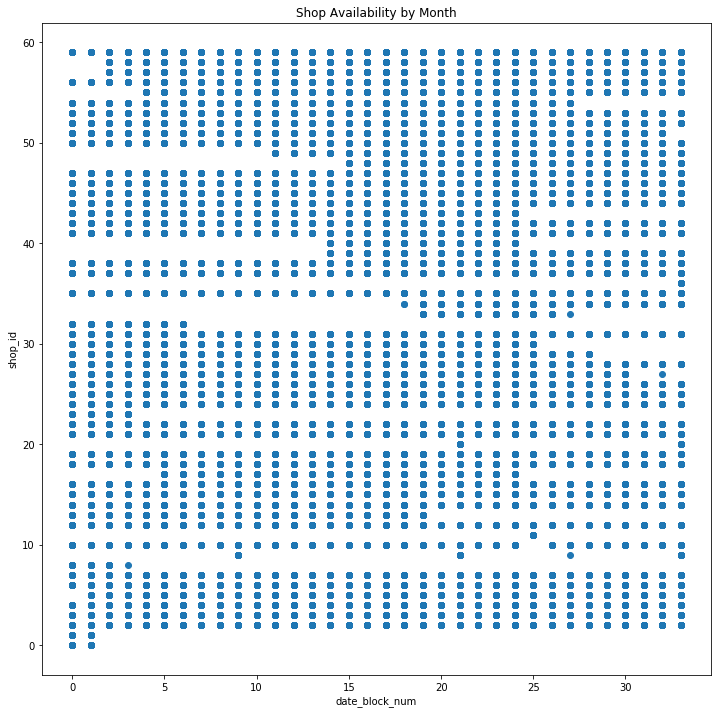

In [6]:
# Plot availability of shop_id by month
_ = plt.figure(figsize=(12,12))
_ = plt.scatter(x = 'date_block_num', y = 'shop_id', data = sales_train)
_ = plt.title('Shop Availability by Month')
_ = plt.xlabel('date_block_num')
_ = plt.ylabel('shop_id')

From the plot above, it's clear that there are a handful of shops that aren't open consistently, while ``shop_id``'s like 0, 1, and 8 haven't been open since early 2013. For purposes of this problem, it may not be necessary to predict sales from shops that aren't in the test set. This would cut back on time, computation speed, and efficiency. If the goal of the project was to predict the future sales of all ``shop_id`` then removing the shops wouldn't be recommended.

In [7]:
# Remove shop_id not found in test set from train set
## Obtain list of shop_id in test set
test_shops = sales_test['shop_id'].unique()

## Filter out shop_id not in test_shops
sales_train_filtered = sales_train[sales_train['shop_id'].isin(test_shops)]

print(len(sales_train_filtered))
print(len(sales_train_filtered['shop_id'].unique()))

1323795
42


In [8]:
# Remove item_id not found in test set from train set
## Obtain list of item_id in test set
test_items = sales_test['item_id'].unique()

## Filter out item_id not in test_shops
sales_train_filtered = sales_train_filtered[sales_train['item_id'].isin(test_items)]

print(len(sales_train_filtered))
print(len(sales_train_filtered['item_id'].unique()))

600159
4716


C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


After removing the shops that don't appear in the test set, the training set has been reduced by nearly 300,000 observations (~18%) and from 59 unique ``shop_id``'s to 42. The same process was done to the ``item_id`` column to futher reduce the number of observations to 600,159 and from 22,169 different items to 4716. The remaining training set comprises of about 37% of the original data. Now we can analyze how well these items and shops did leading up to November 2015.

In [9]:
# Sum item_cnt_day in sales_train_filtered by date and item_category_id
sales_train_cat_grouped = sales_train_filtered[['date_block_num', 'item_cnt_day', 'item_category_id']].groupby(['date_block_num', 'item_category_id']).sum()

sales_train_cat_grouped.reset_index(inplace=True)

In [10]:
# Sum item_cnt_day in sales_train_filtered by date and shop_id
sales_train_shop_grouped = sales_train_filtered[['date_block_num', 'item_cnt_day', 'shop_id']].groupby(['date_block_num', 'shop_id']).sum()

sales_train_shop_grouped.reset_index(inplace=True)

In [15]:
len(sales_train_cat_grouped['item_category_id'].unique())

60

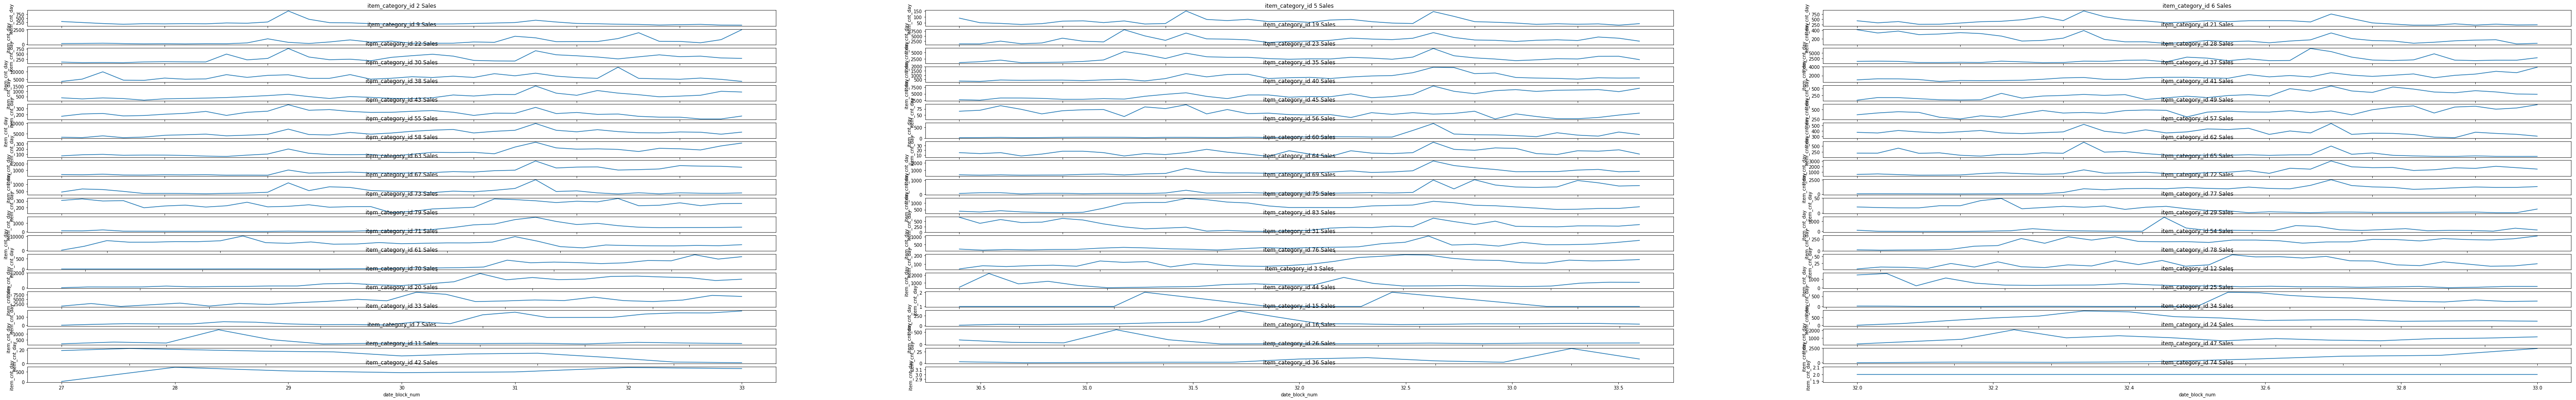

In [22]:
_ = plt.figure(figsize=(,15))
for i in range(len(sales_train_cat_grouped['item_category_id'].unique())):
    item_cat = sales_train_cat_grouped['item_category_id'].unique()[i]
    item_cat_sales = sales_train_cat_grouped[sales_train_cat_grouped['item_category_id'] == item_cat]
    
    _ = plt.subplot(20, 3, i+1)
    _ = plt.plot(item_cat_sales['date_block_num'], item_cat_sales['item_cnt_day'])
    _ = plt.title('item_category_id %i Sales' %item_cat)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('item_cnt_day')

In [ ]:
def plot_item_shop(shop_id, item_cat_id):
    df = sales_train_grouped[(sales_train_grouped['shop_id'] == shop_id) & (sales_train_grouped['item_category_id'] == item_cat_id)]
    
    _ = plt.figure(figsize = (15,15))
    _ = plt.plot(df['date_block_num'], df['item_cnt_day'])

In [ ]:
plot_item_shop(shop_id = 0, item_cat_id = 2)